In [1]:
import os

from IPython.display import clear_output

import numpy as np
import tensorflow as tf

# Graphics and plotting.
import mediapy as media
import matplotlib.pyplot as plt
# Configure MuJoCo to use the EGL rendering backend (requires GPU)
#os.environ['MUJOCO_GL'] = "egl"
os.environ['MUJOCO_GL'] = "glfw" #for mac
try:
  import mujoco
except Exception as e:
  raise e from RuntimeError("Something went wrong during import")
# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)

2024-03-02 09:52:11.498914: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


""

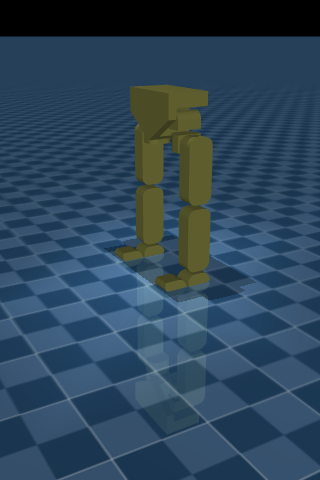

In [2]:
model = mujoco.MjModel.from_xml_path('bipede.xml')
data = mujoco.MjData(model)

ctx = mujoco.GLContext(1000, 1000)
ctx.make_current()

renderer = mujoco.Renderer(model, 480,)

mujoco.mj_forward(model, data)
renderer.update_scene(data)

media.show_image(renderer.render())

In [62]:
def motor_control(data, ref_pos, integral):
    cmd = np.zeros(12)
    state = 180*data.qpos[7:]/np.pi
    vel = data.qvel[6:]
    erreur = state - ref_pos
    integral = np.clip(integral + erreur, -100, 100)
    cmd = np.clip(-17*erreur - 2*vel - 0.1*integral, -100, 100)
    return cmd, integral


def plot(model, data, duration = 2, fps = 25):
    clear_output(wait=True)
    Cmd =[]
    Pos = []
    # Simulate and display video.
    frames = []
    mujoco.mj_resetData(model, data)  # Reset state and time.
    mujoco.mj_forward(model, data)
    integral = np.zeros(12)
    ref_pos = 5*np.ones(12)
    while data.time < duration:
      data.ctrl, integral = motor_control(data, ref_pos, integral)
      print(180*data.qpos[-5]/np.pi)
      Cmd.append(0.01*data.ctrl[-5])
      Pos.append(180*data.qpos[-5]/np.pi)
      mujoco.mj_step(model, data)
      if len(frames) < data.time * fps:
        renderer.update_scene(data)
        pixels = renderer.render()
        frames.append(pixels)
    media.show_video(frames, fps= fps)
    plt.plot(Cmd)
    plt.plot(Pos)
    plt.legend(["Cmd", "Pos"])
    plt.show()

0.0
0.14725949407421565
0.40436751023139605
0.746972164785745
1.1568349545831549
1.617722819267316
2.1155743270626037
2.6356599922226667
3.1636702406063564
3.68715398765939
4.195120016358025
4.678022006623835
5.127825524371197
5.537973228891128
5.900942624043761
6.208845730658932
6.464580304809929
6.672575891601045
6.836718816671056
6.959882235652309
7.045427273130848
7.096588058168934
7.115428349987411
7.104101384661847
7.0644238633543655
6.9980314585019645
6.906723707353228
6.792460030564189
6.656282881689062
6.498568965181386
6.321382294465941
6.125767051299683
5.9158646851276115
5.68121256429174
5.431134824878573
5.172668797918252
4.925595019824692
4.702612439437562
4.519958588306646
4.377656004686895
4.288035425989409
4.255551464829329
4.294416143729052
4.374272457675601
4.516077864810444
4.66295072167013
4.855378715712576
5.012998511343682
5.186831232496301
5.2946102048007635
5.382586464435415
5.386769658349297
5.374443215258856
5.275184683785077
5.180045879288399
5.0022454097106

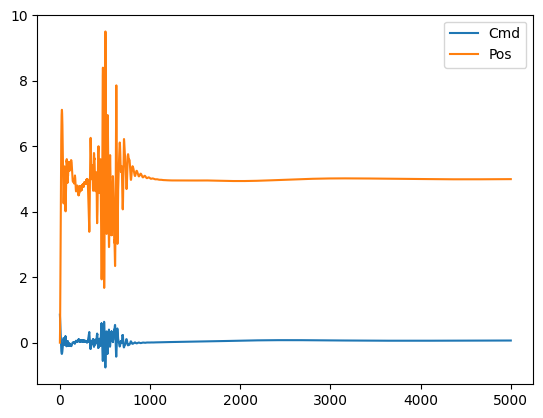

In [63]:
plot(model, data, duration = 10, fps = 25)